This notebook is part of a current project I'm working on that uses place data from the Google Maps API to generate a number of spatial autocorrelation statistics for each of the cities I'm including. The project is studying the the post-conflict recovery of cities from the perspective of post-conflict groups (particularly for religious or ethnic conflict) cohabiting the same cities, using the urban layout as a factor influencing post-conflict recovery. 

Before running this notebook, I used the Places API to collect all places of interest, and below, I process these data and collect them into a single dataframe that I use for statistical analysis. 

THe majority of the code for this project is stored in a private repository, but I am happy to provide individual access to the entire repository to anyone interested - please feel free to reach out to me for this access. 

In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from pysal.viz import splot
from splot.esda import plot_moran
import seaborn as sns
import numpy as np
import contextily

from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import libpysal
from splot import esda as esdaplot


from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
loc_dir = '/mnt/c/Users/natra/Documents/Research/Identity-Conflict/'


city_info_dict = {
    # Kosovo
    "pristina": ['EPSG:9141',f"{loc_dir}kosovo_files/clean/pristina_bounds.geojson",],
    "prizren": ['EPSG:9141',f"{loc_dir}kosovo_files/clean/prizren_locs.geojson"],
    "ferizaj": ['EPSG:9141',f"{loc_dir}kosovo_files/clean/ferizaj_locs_400x400.geojson"],
    "gjakova": ['EPSG:9141',f"{loc_dir}kosovo_files/clean/gjakova_locs_400x400.geojson"],
    "gjilan": ['EPSG:9141',f"{loc_dir}kosovo_files/clean/gjilan_locs_400x400.geojson"],
    "mitrovica": ['EPSG:9141',f"{loc_dir}kosovo_files/clean/mitrovica_locs_400x400.geojson"],
    "peja": ['EPSG:9141',f"{loc_dir}kosovo_files/clean/peja_locs_400x400.geojson"],

    # Macedonia CRS: EPSG:6204
    "skopje": ["EPSG:6204",f"{loc_dir}macedonia_files/clean/skopje_narrow_gdf.geojson"],
    "kumanovo": ["EPSG:6204", f"{loc_dir}macedonia_files/clean/kumanovo_locs.geojson"],
    "bitola": ["EPSG:6204",f"{loc_dir}macedonia_files/clean/bitola_locs_400x400.geojson"],
    "prilep": ["EPSG:6204", f"{loc_dir}macedonia_files/clean/prilep_locs_400x400.geojson"],
    "tetovo": ["EPSG:6204", f"{loc_dir}macedonia_files/clean/tetovo_locs_400x400.geojson"],
    "gostivar": ["EPSG:6204", f"{loc_dir}macedonia_files/clean/gostivar_locs_400x400.geojson"],

    # Montenegro CRS: EPSG:6316 east of 19°30'E (Bijelo Polje, Pljevlja), EPSG:8678 west of 19°30'E (Podgorica, just barely; Niksic)
    # use https://www.arcgis.com/apps/instant/atlas/index.html?appid=0cd1cdee853c413a84bfe4b9a6931f0d to confirm
    # locs east/west of dividing line
    "podgorica": ["EPSG:8678",f"{loc_dir}montenegro_files/clean/podgorica_bounds.geojson"],
    "niksic": ["EPSG:8678",f"{loc_dir}montenegro_files/clean/niksic_locs.geojson"],
    "bar": ["EPSG:8678",f"{loc_dir}montenegro_files/clean/bar_locs_400x400.geojson"],
    "bijelo_polje": ["EPSG:6316",f"{loc_dir}montenegro_files/clean/bijelo_polje_locs_400x400.geojson"],
    "pljevlja": ["EPSG:6316",f"{loc_dir}montenegro_files/clean/pljevlja_locs_400x400.geojson"],

    # Bosnia and Herzegovina EPSG:8677 west of 16°30'E, EPSG:8678 between 16°30'E and 19°30'E (Brcko), 
    # EPSG:6316 east of 19°30'E
    "brcko": ["EPSG:8678",f"{loc_dir}bosnia_herzegovina_files/clean/brcko_locs.geojson"],
    "sarajevo": ["EPSG:10329",f"{loc_dir}bosnia_herzegovina_files/clean/sarajevo_locs_400x400.geojson"],
    "banja_luka": ["EPSG:10329",f"{loc_dir}bosnia_herzegovina_files/clean/banja_luka_locs_400x400.geojson"],
    "tuzla": ["EPSG:10329",f"{loc_dir}bosnia_herzegovina_files/clean/tuzla_locs_400x400.geojson"],

    # Iraq CRS: EPSG:6646
    "baghdad": ["EPSG:6646",f"{loc_dir}iraq_files/clean/baghdad_locs.geojson"],

    # Lebanon CRS: EPSG:22770
    "beirut": ["EPSG:22770",f"{loc_dir}lebanon_files/clean/beirut_locs_300x300.geojson"],

    # Bangladesh CRS: epsg:9678
    "chittagong": ["EPSG:9678",f"{loc_dir}bangladesh_files/clean/chittagong_locs_250x250.geojson"],

    # Timor-Leste CRS: EPSG:32751
    "dili": ["EPSG:32751",f"{loc_dir}timor_leste_files/clean/dili_locs_400x400.geojson"],
}

In [5]:
# define location type groups
med_types = ["hospital","doctor","dental_clinic","medical_lab","health",
             "veterinary_care","pharmacy"]
relig_types  = ["church","mosque","place_of_worship","synagogue","hindu_temple"]
culture_types = ["museum","historical_landmark","art_gallery","library",
                 "community_center","cultural_center","performing_arts_theater",
                 "tourist_attraction","embassy"]
law_types = ["police","local_government_office","courthouse","city_hall","lawyer"]
educ_types = ["school","secondary_school","primary_school","preschool"]

# create sections for all city types
# also need to check for 
def create_city_types(city_gdf):
    relig_city = city_gdf[city_gdf['primaryType'].isin(relig_types)]
    med_city = city_gdf[city_gdf['primaryType'].isin(med_types)]
    culture_city = city_gdf[city_gdf['primaryType'].isin(culture_types)]
    law_city = city_gdf[city_gdf['primaryType'].isin(law_types)]
    educ_city = city_gdf[city_gdf['primaryType'].isin(educ_types)]
    na_city = city_gdf[city_gdf['primaryType'].isna()]

    return([relig_city,med_city,culture_city,law_city,educ_city,na_city])


# types of religious sites keywords to search
catholic_church = ["st ","st.","saint","catholic","catholi","katolička",
                   "cathedral","orthodox"]
protestant_church = ['protestant']
mormon_church = ['latter']

In [15]:
def get_religious_site_autocorrs(city_name, city_info_dict, relig_types, summary_data,
                                 primary_relig_types = None, weights_k=2, weights_func="triangular"):
    """
    For each json of site locations, run analysis on all religious sites
    Inputs:
        city_file: city name corresponding to a key in city_info_dict
        summary_data (dict): dictionary to store results

        primary_relig_types: either leave None, if want to dynamically select buildings from top two dominant religions,
                                or list of top religious types in order (eg, ["church","mosque])
    """
    print("Running analysis for city ",city_name)
    loc_gdf = gpd.read_file(city_info_dict[city_name][1])
    # only need religious sites for now
    loc_relig = loc_gdf[loc_gdf['primaryType'].isin(relig_types)]

    loc_relig = loc_relig[['primaryType','latitude','longitude','geometry']]

    # get the top two kinds of religious sites by their occurrence in the city 
    # this allows us to have the dominant religion always be 'H' in the Local Moran's
    if primary_relig_types == None:
        top_religs = loc_relig.groupby('primaryType').count().reset_index()
        # get the most-occuring type of religious site
        primary_relig_type_1 = top_religs.iloc[top_religs['geometry'].idxmax()]['primaryType']
        # remove this type from the aggregated counts
        top_religs = top_religs[top_religs['primaryType']!= primary_relig_type_1].reset_index(drop=True)
        # get the second-most common type 
        primary_relig_type_2 = top_religs.iloc[top_religs['geometry'].idxmax()]['primaryType']
    else:
        primary_relig_type_1 = primary_relig_types[0]
        primary_relig_type_2 = primary_relig_types[1]

    print(f"Using dominant religious site type {primary_relig_type_1} and second-most common site type {primary_relig_type_2}")    

    loc_twotypes_gdf = loc_relig[loc_relig['primaryType'].isin([primary_relig_type_1, primary_relig_type_2])].reset_index()
    loc_twotypes_gdf.loc[:,'type_one_flag'] = np.where(loc_twotypes_gdf['primaryType']==primary_relig_type_1,1,0)
    # use adaptive bandwidth (fixed=False) to account for uneven distribution of points
    w = weights.distance.Kernel.from_dataframe(loc_twotypes_gdf, fixed=False, 
                                               weights=weights_k, function=weights_func)

    # Global Moran's I
    moran = esda.moran.Moran(loc_twotypes_gdf["type_one_flag"], w)
    print(f"Moran's I for {city_name} and religious sites {primary_relig_type_1} and {primary_relig_type_2}:",moran.I)
    print("\tMoran's I p-stat:", moran.p_sim)

    # Global Geary / Anselin
    geary = esda.geary.Geary(loc_twotypes_gdf["type_one_flag"], w)
    print(f"Geary c for {city_name} and religious sites {primary_relig_type_1} and {primary_relig_type_2}:",geary.C)
    print("\tMoran's I p-stat:",geary.p_sim)


    # local Moran's I
    print("Running local Moran's I:...")
    lisa = esda.moran.Moran_Local(loc_twotypes_gdf["type_one_flag"], w)
    # plot local significance 
    esdaplot.lisa_cluster(lisa, loc_twotypes_gdf, p=0.05)
    # calculate percentage occurring not by chancee
    print(f"Clusters expecting to occur not by chance: {(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)}")

    # create dataframe version of significance measures by type seen in plots above
    # Assign pseudo P-values to `db`
    loc_twotypes_gdf["p-sim"] = lisa.p_sim
    # `1` if significant (at 5% confidence level), `0` otherwise
    sig = 1 * (lisa.p_sim < 0.05)
    # Assign significance flag to `db`
    loc_twotypes_gdf["sig"] = sig

    # Pick as part of a quadrant only significant polygons,
    # assign `0` otherwise (Non-significant polygons)
    spots = lisa.q * sig
    # Mapping from value to name (as a dict)
    spots_labels = {
        0: "Non-Significant",
        1: "HH",
        2: "LH",
        3: "LL",
        4: "HL",
    }
    # Create column in `db` with labels for each polygon
    loc_twotypes_gdf["labels"] = pd.Series(
        # First initialise a Series using values and `db` index
        spots,
        index=loc_twotypes_gdf.index
        # Then map each value to corresponding label based
        # on the `spots_labels` mapping
    ).map(spots_labels)
    # print summarized values
    print(loc_twotypes_gdf["labels"].value_counts())

    # identify which labels of all possible labels have no values, 
    no_val_labels = [a for a in spots_labels.values() if a not in loc_twotypes_gdf["labels"].unique()]

    print("num distinct records assigning labels to: ",len(spots))
    local_morans_dict = {}
    for lab in spots_labels.values():
        if lab in no_val_labels:
            local_morans_dict[lab] = 0
        else:
            local_morans_dict[lab] = loc_twotypes_gdf["labels"].value_counts()[lab].item() / len(spots)


    # Local Getis and Ord's
    #NOTE: need to cast to floats to avoid error, as per this git issue: https://github.com/pysal/esda/issues/275
    # Gi - omits the value at site in local summary
    go_i = esda.getisord.G_Local(loc_twotypes_gdf["type_one_flag"].astype('float64'), w)
    # Gi* - include site's own value in local summary
    go_i_star = esda.getisord.G_Local(loc_twotypes_gdf["type_one_flag"].astype('float64'), w, star=True)
    print("Prop Gi's Significant:", (go_i.p_sim<0.05).sum() / (len(go_i.p_sim)))
    print("Prop Gi*'s Significant:", (go_i_star.p_sim < 0.05).sum() / (len(go_i_star.p_sim)))


    summary_data[city_name] = {'city_name':city_name,
                               'primary_type_1':primary_relig_type_1,
                               'primary_type_2':primary_relig_type_2,
                               'num_primary_type_1':loc_twotypes_gdf[loc_twotypes_gdf['primaryType']==primary_relig_type_1].shape[0],
                               'num_primary_type_2':loc_twotypes_gdf[loc_twotypes_gdf['primaryType']==primary_relig_type_2].shape[0],
                               'global_morans_i':moran.I,
                               'global_morans_i_pstat':moran.p_sim,
                               'global_gearys':geary.C,
                               'global_gearys_pstat':geary.p_sim,
                               'local_gi_prop_sig':(go_i.p_sim<0.05).sum() / (len(go_i.p_sim)),
                               'local_gi_star_prop_sig':(go_i_star.p_sim < 0.05).sum() / (len(go_i_star.p_sim)),
                               'local_morans_prop_sig':(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)}
    summary_data[city_name].update(local_morans_dict)

    print(f"Summary data dict for city {city_name}:",summary_data[city_name])

    return(summary_data)

    

Skipping field types: unsupported OGR type: 5


Running analysis for city  pristina
Using dominant religious site type mosque and second-most common site type church
Moran's I for pristina and religious sites mosque and church: 0.8586367020267107
	Moran's I p-stat: 0.043
Geary c for pristina and religious sites mosque and church: 0.13107490895884613
	Moran's I p-stat: 0.035
Running local Moran's I:...


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)


Clusters expecting to occur not by chance: 32.075471698113205
labels
Non-Significant    36
LL                  8
HH                  8
HL                  1
Name: count, dtype: int64
num distinct records assigning labels to:  53


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
Skipping field types: unsupported OGR type: 5


Prop Gi's Significant: 0.8867924528301887
Prop Gi*'s Significant: 0.24528301886792453
Summary data dict for city pristina: {'city_name': 'pristina', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 38, 'num_primary_type_2': 15, 'global_morans_i': np.float64(0.8586367020267107), 'global_morans_i_pstat': np.float64(0.043), 'global_gearys': np.float64(0.13107490895884613), 'global_gearys_pstat': np.float64(0.035), 'local_gi_prop_sig': np.float64(0.8867924528301887), 'local_gi_star_prop_sig': np.float64(0.24528301886792453), 'local_morans_prop_sig': np.float64(32.075471698113205), 'Non-Significant': 0.6792452830188679, 'HH': 0.1509433962264151, 'LH': 0, 'LL': 0.1509433962264151, 'HL': 0.018867924528301886}
Running analysis for city  prizren
Using dominant religious site type mosque and second-most common site type church
Moran's I for prizren and religious sites mosque and church: 0.9271174871545279
	Moran's I p-stat: 0.002
Geary c for prizren and religious sit

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconne

Using dominant religious site type church and second-most common site type mosque
Moran's I for ferizaj and religious sites church and mosque: 0.8244196377665172
	Moran's I p-stat: 0.174
Geary c for ferizaj and religious sites church and mosque: 0.16094866538069258
	Moran's I p-stat: 0.164
Running local Moran's I:...
Clusters expecting to occur not by chance: 16.666666666666668
labels
Non-Significant    10
HH                  1
LL                  1
Name: count, dtype: int64
num distinct records assigning labels to:  12


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
Skipping field types: unsupported OGR type: 5


Prop Gi's Significant: 0.5833333333333334
Prop Gi*'s Significant: 0.08333333333333333
Summary data dict for city ferizaj: {'city_name': 'ferizaj', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 6, 'num_primary_type_2': 6, 'global_morans_i': np.float64(0.8244196377665172), 'global_morans_i_pstat': np.float64(0.174), 'global_gearys': np.float64(0.16094866538069258), 'global_gearys_pstat': np.float64(0.164), 'local_gi_prop_sig': np.float64(0.5833333333333334), 'local_gi_star_prop_sig': np.float64(0.08333333333333333), 'local_morans_prop_sig': np.float64(16.666666666666668), 'Non-Significant': 0.8333333333333334, 'HH': 0.08333333333333333, 'LH': 0, 'LL': 0.08333333333333333, 'HL': 0}
Running analysis for city  gjakova
Using dominant religious site type mosque and second-most common site type church
Moran's I for gjakova and religious sites mosque and church: 0.7172655538637351
	Moran's I p-stat: 0.181
Geary c for gjakova and religious sites mosque and church:

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconne

Prop Gi's Significant: 0.7931034482758621
Prop Gi*'s Significant: 0.3103448275862069
Summary data dict for city gjakova: {'city_name': 'gjakova', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 19, 'num_primary_type_2': 10, 'global_morans_i': np.float64(0.7172655538637351), 'global_morans_i_pstat': np.float64(0.181), 'global_gearys': np.float64(0.278953778557991), 'global_gearys_pstat': np.float64(0.202), 'local_gi_prop_sig': np.float64(0.7931034482758621), 'local_gi_star_prop_sig': np.float64(0.3103448275862069), 'local_morans_prop_sig': np.float64(20.689655172413794), 'Non-Significant': 0.7931034482758621, 'HH': 0.10344827586206896, 'LH': 0, 'LL': 0.06896551724137931, 'HL': 0.034482758620689655}
Running analysis for city  gjilan
Using dominant religious site type mosque and second-most common site type church
Moran's I for gjilan and religious sites mosque and church: 0.8565538686740635
	Moran's I p-stat: 0.134


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)


Geary c for gjilan and religious sites mosque and church: 0.13237722584894926
	Moran's I p-stat: 0.143
Running local Moran's I:...
Clusters expecting to occur not by chance: 17.647058823529413
labels
Non-Significant    14
HH                  1
LL                  1
HL                  1
Name: count, dtype: int64
num distinct records assigning labels to:  17


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
Skipping field types: unsupported OGR type: 5


Prop Gi's Significant: 0.8823529411764706
Prop Gi*'s Significant: 0.29411764705882354
Summary data dict for city gjilan: {'city_name': 'gjilan', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 13, 'num_primary_type_2': 4, 'global_morans_i': np.float64(0.8565538686740635), 'global_morans_i_pstat': np.float64(0.134), 'global_gearys': np.float64(0.13237722584894926), 'global_gearys_pstat': np.float64(0.143), 'local_gi_prop_sig': np.float64(0.8823529411764706), 'local_gi_star_prop_sig': np.float64(0.29411764705882354), 'local_morans_prop_sig': np.float64(17.647058823529413), 'Non-Significant': 0.8235294117647058, 'HH': 0.058823529411764705, 'LH': 0, 'LL': 0.058823529411764705, 'HL': 0.058823529411764705}
Running analysis for city  mitrovica
Using dominant religious site type mosque and second-most common site type church
Moran's I for mitrovica and religious sites mosque and church: 0.8831360014893267
	Moran's I p-stat: 0.102
Geary c for mitrovica and religiou

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconne

Prop Gi's Significant: 0.92
Prop Gi*'s Significant: 0.28
Summary data dict for city mitrovica: {'city_name': 'mitrovica', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 20, 'num_primary_type_2': 5, 'global_morans_i': np.float64(0.8831360014893267), 'global_morans_i_pstat': np.float64(0.102), 'global_gearys': np.float64(0.08126170742550679), 'global_gearys_pstat': np.float64(0.103), 'local_gi_prop_sig': np.float64(0.92), 'local_gi_star_prop_sig': np.float64(0.28), 'local_morans_prop_sig': np.float64(28.0), 'Non-Significant': 0.72, 'HH': 0.16, 'LH': 0, 'LL': 0.12, 'HL': 0}
Running analysis for city  peja
Using dominant religious site type mosque and second-most common site type church
Moran's I for peja and religious sites mosque and church: 0.9275829928329793
	Moran's I p-stat: 0.002
Geary c for peja and religious sites mosque and church: 0.07202281376410057
	Moran's I p-stat: 0.005
Running local Moran's I:...
Clusters expecting to occur not by chance: 21.

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconne

Prop Gi's Significant: 0.7575757575757576
Prop Gi*'s Significant: 0.36363636363636365
Summary data dict for city peja: {'city_name': 'peja', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 19, 'num_primary_type_2': 14, 'global_morans_i': np.float64(0.9275829928329793), 'global_morans_i_pstat': np.float64(0.002), 'global_gearys': np.float64(0.07202281376410057), 'global_gearys_pstat': np.float64(0.005), 'local_gi_prop_sig': np.float64(0.7575757575757576), 'local_gi_star_prop_sig': np.float64(0.36363636363636365), 'local_morans_prop_sig': np.float64(21.21212121212121), 'Non-Significant': 0.7878787878787878, 'HH': 0.18181818181818182, 'LH': 0, 'LL': 0.030303030303030304, 'HL': 0}
Running analysis for city  skopje
Using dominant religious site type church and second-most common site type mosque
Moran's I for skopje and religious sites church and mosque: 0.8983855668261493
	Moran's I p-stat: 0.001
Geary c for skopje and religious sites church and mosque: 0.1026

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconne

Prop Gi's Significant: 0.8877551020408163
Prop Gi*'s Significant: 0.25510204081632654
Summary data dict for city skopje: {'city_name': 'skopje', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 65, 'num_primary_type_2': 33, 'global_morans_i': np.float64(0.8983855668261493), 'global_morans_i_pstat': np.float64(0.001), 'global_gearys': np.float64(0.1026938220701715), 'global_gearys_pstat': np.float64(0.001), 'local_gi_prop_sig': np.float64(0.8877551020408163), 'local_gi_star_prop_sig': np.float64(0.25510204081632654), 'local_morans_prop_sig': np.float64(10.204081632653061), 'Non-Significant': 0.8979591836734694, 'HH': 0.030612244897959183, 'LH': 0, 'LL': 0.07142857142857142, 'HL': 0}
Running analysis for city  kumanovo
Using dominant religious site type church and second-most common site type mosque
Moran's I for kumanovo and religious sites church and mosque: 0.8574981884601786
	Moran's I p-stat: 0.126
Geary c for kumanovo and religious sites church and mosq

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
Skipping field types: unsupported OGR type: 5
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)


Prop Gi's Significant: 0.875
Prop Gi*'s Significant: 0.0625
Summary data dict for city kumanovo: {'city_name': 'kumanovo', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 12, 'num_primary_type_2': 4, 'global_morans_i': np.float64(0.8574981884601786), 'global_morans_i_pstat': np.float64(0.126), 'global_gearys': np.float64(0.12976381160846456), 'global_gearys_pstat': np.float64(0.118), 'local_gi_prop_sig': np.float64(0.875), 'local_gi_star_prop_sig': np.float64(0.0625), 'local_morans_prop_sig': np.float64(6.25), 'Non-Significant': 0.9375, 'HH': 0, 'LH': 0, 'LL': 0.0625, 'HL': 0}
Running analysis for city  bitola
Using dominant religious site type church and second-most common site type mosque
Moran's I for bitola and religious sites church and mosque: 0.6850582566211173
	Moran's I p-stat: 0.282
Geary c for bitola and religious sites church and mosque: 0.26964703450017297
	Moran's I p-stat: 0.448
Running local Moran's I:...
Clusters expecting to occur not by 

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
Skipping field types: unsupported OGR type: 5


Prop Gi's Significant: 0.9523809523809523
Prop Gi*'s Significant: 0.14285714285714285
Summary data dict for city bitola: {'city_name': 'bitola', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 38, 'num_primary_type_2': 4, 'global_morans_i': np.float64(0.6850582566211173), 'global_morans_i_pstat': np.float64(0.282), 'global_gearys': np.float64(0.26964703450017297), 'global_gearys_pstat': np.float64(0.448), 'local_gi_prop_sig': np.float64(0.9523809523809523), 'local_gi_star_prop_sig': np.float64(0.14285714285714285), 'local_morans_prop_sig': np.float64(38.095238095238095), 'Non-Significant': 0.6190476190476191, 'HH': 0.2619047619047619, 'LH': 0, 'LL': 0.09523809523809523, 'HL': 0.023809523809523808}
Running analysis for city  prilep
Using dominant religious site type church and second-most common site type mosque
Moran's I for prilep and religious sites church and mosque: 0.5529618993425379
	Moran's I p-stat: 0.067
Geary c for prilep and religious sites chur

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconne

Prop Gi's Significant: 1.0
Prop Gi*'s Significant: 0.25
Summary data dict for city prilep: {'city_name': 'prilep', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 15, 'num_primary_type_2': 1, 'global_morans_i': np.float64(0.5529618993425379), 'global_morans_i_pstat': np.float64(0.067), 'global_gearys': np.float64(0.4258115864141974), 'global_gearys_pstat': np.float64(0.128), 'local_gi_prop_sig': np.float64(1.0), 'local_gi_star_prop_sig': np.float64(0.25), 'local_morans_prop_sig': np.float64(25.0), 'Non-Significant': 0.75, 'HH': 0.125, 'LH': 0, 'LL': 0.0625, 'HL': 0.0625}
Running analysis for city  tetovo
Using dominant religious site type mosque and second-most common site type church
Moran's I for tetovo and religious sites mosque and church: 0.9089683718619626
	Moran's I p-stat: 0.032
Geary c for tetovo and religious sites mosque and church: 0.06384967551295083
	Moran's I p-stat: 0.011
Running local Moran's I:...
Clusters expecting to occur not by chance

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconne

Prop Gi's Significant: 0.8846153846153846
Prop Gi*'s Significant: 0.11538461538461539
Summary data dict for city tetovo: {'city_name': 'tetovo', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 20, 'num_primary_type_2': 6, 'global_morans_i': np.float64(0.9089683718619626), 'global_morans_i_pstat': np.float64(0.032), 'global_gearys': np.float64(0.06384967551295083), 'global_gearys_pstat': np.float64(0.011), 'local_gi_prop_sig': np.float64(0.8846153846153846), 'local_gi_star_prop_sig': np.float64(0.11538461538461539), 'local_morans_prop_sig': np.float64(53.84615384615385), 'Non-Significant': 0.46153846153846156, 'HH': 0.34615384615384615, 'LH': 0, 'LL': 0.19230769230769232, 'HL': 0}
Running analysis for city  gostivar
Using dominant religious site type mosque and second-most common site type church
Moran's I for gostivar and religious sites mosque and church: 0.9067340472304358
	Moran's I p-stat: 0.095
Geary c for gostivar and religious sites mosque and churc

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
Skipping field types: unsupported OGR type: 5


Prop Gi's Significant: 0.9285714285714286
Prop Gi*'s Significant: 0.21428571428571427
Summary data dict for city gostivar: {'city_name': 'gostivar', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 11, 'num_primary_type_2': 3, 'global_morans_i': np.float64(0.9067340472304358), 'global_morans_i_pstat': np.float64(0.095), 'global_gearys': np.float64(0.12956518630507843), 'global_gearys_pstat': np.float64(0.202), 'local_gi_prop_sig': np.float64(0.9285714285714286), 'local_gi_star_prop_sig': np.float64(0.21428571428571427), 'local_morans_prop_sig': np.float64(28.571428571428573), 'Non-Significant': 0.7142857142857143, 'HH': 0.14285714285714285, 'LH': 0, 'LL': 0.14285714285714285, 'HL': 0}
Running analysis for city  podgorica
Using dominant religious site type church and second-most common site type mosque
Moran's I for podgorica and religious sites church and mosque: 0.7904542076569887
	Moran's I p-stat: 0.195
Geary c for podgorica and religious sites church an

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconne

Prop Gi's Significant: 0.8571428571428571
Prop Gi*'s Significant: 0.17857142857142858
Summary data dict for city podgorica: {'city_name': 'podgorica', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 21, 'num_primary_type_2': 7, 'global_morans_i': np.float64(0.7904542076569887), 'global_morans_i_pstat': np.float64(0.195), 'global_gearys': np.float64(0.18798385110368973), 'global_gearys_pstat': np.float64(0.171), 'local_gi_prop_sig': np.float64(0.8571428571428571), 'local_gi_star_prop_sig': np.float64(0.17857142857142858), 'local_morans_prop_sig': np.float64(7.142857142857143), 'Non-Significant': 0.9285714285714286, 'HH': 0, 'LH': 0, 'LL': 0.07142857142857142, 'HL': 0}
Running analysis for city  niksic
Using dominant religious site type church and second-most common site type mosque
Moran's I for niksic and religious sites church and mosque: 0.6792694780882115
	Moran's I p-stat: 0.251
Geary c for niksic and religious sites church and mosque: 0.16036533705073

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconne

Prop Gi's Significant: 1.0
Prop Gi*'s Significant: 0.10526315789473684
Summary data dict for city niksic: {'city_name': 'niksic', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 18, 'num_primary_type_2': 1, 'global_morans_i': np.float64(0.6792694780882115), 'global_morans_i_pstat': np.float64(0.251), 'global_gearys': np.float64(0.1603653370507377), 'global_gearys_pstat': np.float64(0.475), 'local_gi_prop_sig': np.float64(1.0), 'local_gi_star_prop_sig': np.float64(0.10526315789473684), 'local_morans_prop_sig': np.float64(84.21052631578948), 'Non-Significant': 0.15789473684210525, 'HH': 0.7894736842105263, 'LH': 0, 'LL': 0.05263157894736842, 'HL': 0}
Running analysis for city  bar
Using dominant religious site type church and second-most common site type mosque
Moran's I for bar and religious sites church and mosque: 0.92772100078901
	Moran's I p-stat: 0.007
Geary c for bar and religious sites church and mosque: 0.04596565215237711
	Moran's I p-stat: 0.003
R

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconne

Prop Gi's Significant: 0.8928571428571429
Prop Gi*'s Significant: 0.14285714285714285
Summary data dict for city bar: {'city_name': 'bar', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 22, 'num_primary_type_2': 6, 'global_morans_i': np.float64(0.92772100078901), 'global_morans_i_pstat': np.float64(0.007), 'global_gearys': np.float64(0.04596565215237711), 'global_gearys_pstat': np.float64(0.003), 'local_gi_prop_sig': np.float64(0.8928571428571429), 'local_gi_star_prop_sig': np.float64(0.14285714285714285), 'local_morans_prop_sig': np.float64(10.714285714285714), 'Non-Significant': 0.8928571428571429, 'HH': 0.03571428571428571, 'LH': 0, 'LL': 0.07142857142857142, 'HL': 0}
Running analysis for city  bijelo_polje
Using dominant religious site type church and second-most common site type mosque
Moran's I for bijelo_polje and religious sites church and mosque: 0.6196308295304305
	Moran's I p-stat: 0.464
Geary c for bijelo_polje and religious sites church and m

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconne

Prop Gi's Significant: 0.6666666666666666
Prop Gi*'s Significant: 0.2222222222222222
Summary data dict for city bijelo_polje: {'city_name': 'bijelo_polje', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 5, 'num_primary_type_2': 4, 'global_morans_i': np.float64(0.6196308295304305), 'global_morans_i_pstat': np.float64(0.464), 'global_gearys': np.float64(0.3356457820216233), 'global_gearys_pstat': np.float64(0.477), 'local_gi_prop_sig': np.float64(0.6666666666666666), 'local_gi_star_prop_sig': np.float64(0.2222222222222222), 'local_morans_prop_sig': np.float64(22.22222222222222), 'Non-Significant': 0.7777777777777778, 'HH': 0.1111111111111111, 'LH': 0, 'LL': 0.1111111111111111, 'HL': 0}
Running analysis for city  pljevlja
Using dominant religious site type mosque and second-most common site type church
Moran's I for pljevlja and religious sites mosque and church: 0.9152819429053661
	Moran's I p-stat: 0.168
Geary c for pljevlja and religious sites mosque and 

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
Skipping field types: unsupported OGR type: 5


Prop Gi's Significant: 0.7142857142857143
Prop Gi*'s Significant: 0.0
Summary data dict for city pljevlja: {'city_name': 'pljevlja', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 5, 'num_primary_type_2': 2, 'global_morans_i': np.float64(0.9152819429053661), 'global_morans_i_pstat': np.float64(0.168), 'global_gearys': np.float64(0.05083083425678044), 'global_gearys_pstat': np.float64(0.104), 'local_gi_prop_sig': np.float64(0.7142857142857143), 'local_gi_star_prop_sig': np.float64(0.0), 'local_morans_prop_sig': np.float64(42.857142857142854), 'Non-Significant': 0.5714285714285714, 'HH': 0.14285714285714285, 'LH': 0, 'LL': 0.2857142857142857, 'HL': 0}
Running analysis for city  brcko
Using dominant religious site type church and second-most common site type mosque
Moran's I for brcko and religious sites church and mosque: 0.8580232047943362
	Moran's I p-stat: 0.086
Geary c for brcko and religious sites church and mosque: 0.12862075763017336
	Moran's I p-sta

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


Prop Gi's Significant: 0.631578947368421
Prop Gi*'s Significant: 0.15789473684210525
Summary data dict for city brcko: {'city_name': 'brcko', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 11, 'num_primary_type_2': 8, 'global_morans_i': np.float64(0.8580232047943362), 'global_morans_i_pstat': np.float64(0.086), 'global_gearys': np.float64(0.12862075763017336), 'global_gearys_pstat': np.float64(0.075), 'local_gi_prop_sig': np.float64(0.631578947368421), 'local_gi_star_prop_sig': np.float64(0.15789473684210525), 'local_morans_prop_sig': np.float64(21.05263157894737), 'Non-Significant': 0.7894736842105263, 'HH': 0.05263157894736842, 'LH': 0, 'LL': 0.15789473684210525, 'HL': 0}
Running analysis for city  sarajevo


Skipping field types: unsupported OGR type: 5
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)


Using dominant religious site type mosque and second-most common site type church
Moran's I for sarajevo and religious sites mosque and church: 0.8622344815031653
	Moran's I p-stat: 0.001
Geary c for sarajevo and religious sites mosque and church: 0.15095900790594916
	Moran's I p-stat: 0.002
Running local Moran's I:...
Clusters expecting to occur not by chance: 27.49003984063745
labels
Non-Significant    182
LL                  30
HH                  24
HL                  15
Name: count, dtype: int64
num distinct records assigning labels to:  251


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
Skipping field types: unsupported OGR type: 5


Prop Gi's Significant: 0.9163346613545816
Prop Gi*'s Significant: 0.22310756972111553
Summary data dict for city sarajevo: {'city_name': 'sarajevo', 'primary_type_1': 'mosque', 'primary_type_2': 'church', 'num_primary_type_1': 205, 'num_primary_type_2': 46, 'global_morans_i': np.float64(0.8622344815031653), 'global_morans_i_pstat': np.float64(0.001), 'global_gearys': np.float64(0.15095900790594916), 'global_gearys_pstat': np.float64(0.002), 'local_gi_prop_sig': np.float64(0.9163346613545816), 'local_gi_star_prop_sig': np.float64(0.22310756972111553), 'local_morans_prop_sig': np.float64(27.49003984063745), 'Non-Significant': 0.7250996015936255, 'HH': 0.09561752988047809, 'LH': 0, 'LL': 0.11952191235059761, 'HL': 0.05976095617529881}
Running analysis for city  banja_luka
Using dominant religious site type church and second-most common site type mosque
Moran's I for banja_luka and religious sites church and mosque: 0.8812628234081655
	Moran's I p-stat: 0.021
Geary c for banja_luka and rel

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:979: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize=figsize)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equi

Prop Gi's Significant: 0.8727272727272727
Prop Gi*'s Significant: 0.12727272727272726
Summary data dict for city banja_luka: {'city_name': 'banja_luka', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 43, 'num_primary_type_2': 12, 'global_morans_i': np.float64(0.8812628234081655), 'global_morans_i_pstat': np.float64(0.021), 'global_gearys': np.float64(0.1055415879164517), 'global_gearys_pstat': np.float64(0.024), 'local_gi_prop_sig': np.float64(0.8727272727272727), 'local_gi_star_prop_sig': np.float64(0.12727272727272726), 'local_morans_prop_sig': np.float64(74.54545454545455), 'Non-Significant': 0.2545454545454545, 'HH': 0.5636363636363636, 'LH': 0, 'LL': 0.14545454545454545, 'HL': 0.03636363636363636}
Running analysis for city  tuzla
Using dominant religious site type mosque and second-most common site type church
Moran's I for tuzla and religious sites mosque and church: 0.708853207201544
	Moran's I p-stat: 0.166
Geary c for tuzla and religious sites mo

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconne

Using dominant religious site type mosque and second-most common site type church
Moran's I for baghdad and religious sites mosque and church: nan
	Moran's I p-stat: 0.001
Geary c for baghdad and religious sites mosque and church: nan
	Moran's I p-stat: 0.001
Running local Moran's I:...


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 101 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 240 disconnected components.
 There are 157 islands with ids: 20, 23, 32, 44, 57, 59, 66, 80, 82, 102, 105, 113, 116, 126, 133, 139, 145, 152, 159, 170, 173, 179, 189, 199, 231, 237, 243, 245, 251, 258, 260, 264, 269, 274, 279, 289, 301, 304, 313, 325, 332, 335, 339, 341, 345, 347, 364, 376, 380, 382, 395, 398, 407, 417, 426, 432, 434, 450, 468, 492, 500, 505, 509, 514, 536, 542, 548, 568, 577, 590, 593, 597, 612, 619, 621, 643, 647, 651, 654, 659, 666, 670, 674, 678, 683, 705, 716, 736, 742, 746, 760, 768, 785, 788, 791, 808, 812, 815, 818, 832, 836, 845, 848, 868

Clusters expecting to occur not by chance: 15.05226480836237
labels
Non-Significant    1219
HH                  171
LL                   31
HL                   14
Name: count, dtype: int64
num distinct records assigning labels to:  1435
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 59, ' is an island (no neighbors)')
('WARNING: ', 66, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 82, ' is an island (no neighbors)')
('WARNING: ', 102, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 113, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 126, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARN

Skipping field types: unsupported OGR type: 5
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix

Using dominant religious site type church and second-most common site type mosque
Moran's I for beirut and religious sites church and mosque: 0.9243481154984213
	Moran's I p-stat: 0.001
Geary c for beirut and religious sites church and mosque: 0.07202441470241296
	Moran's I p-stat: 0.001
Running local Moran's I:...
Clusters expecting to occur not by chance: 56.888888888888886
labels
HH                 107
Non-Significant     97
LL                  21
Name: count, dtype: int64
num distinct records assigning labels to:  225
Prop Gi's Significant: 0.8666666666666667
Prop Gi*'s Significant: 0.28888888888888886
Summary data dict for city beirut: {'city_name': 'beirut', 'primary_type_1': 'church', 'primary_type_2': 'mosque', 'num_primary_type_1': 134, 'num_primary_type_2': 91, 'global_morans_i': np.float64(0.9243481154984213), 'global_morans_i_pstat': np.float64(0.001), 'global_gearys': np.float64(0.07202441470241296), 'global_gearys_pstat': np.float64(0.001), 'local_gi_prop_sig': np.float64

Skipping field types: unsupported OGR type: 5


Using dominant religious site type mosque and second-most common site type hindu_temple


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 93 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)


Moran's I for chittagong and religious sites mosque and hindu_temple: nan
	Moran's I p-stat: 0.001
Geary c for chittagong and religious sites mosque and hindu_temple: nan
	Moran's I p-stat: 0.001
Running local Moran's I:...
Clusters expecting to occur not by chance: 61.169702780441035
labels
HH                 925
Non-Significant    810
LL                 219
HL                 132
Name: count, dtype: int64
num distinct records assigning labels to:  2086


/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 93 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
Skipping field types: unsupported OGR type: 5
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not ful

Prop Gi's Significant: 0.9467881112176414
Prop Gi*'s Significant: 0.2564717162032598
Summary data dict for city chittagong: {'city_name': 'chittagong', 'primary_type_1': 'mosque', 'primary_type_2': 'hindu_temple', 'num_primary_type_1': 1756, 'num_primary_type_2': 330, 'global_morans_i': np.float64(nan), 'global_morans_i_pstat': np.float64(0.001), 'global_gearys': np.float64(nan), 'global_gearys_pstat': np.float64(0.001), 'local_gi_prop_sig': np.float64(0.9467881112176414), 'local_gi_star_prop_sig': np.float64(0.2564717162032598), 'local_morans_prop_sig': np.float64(61.169702780441035), 'Non-Significant': 0.3883029721955896, 'HH': 0.4434324065196548, 'LH': 0, 'LL': 0.1049856184084372, 'HL': 0.06327900287631831}
Running analysis for city  dili
Using dominant religious site type church and second-most common site type mosque
Moran's I for dili and religious sites church and mosque: nan
	Moran's I p-stat: 0.001
Geary c for dili and religious sites church and mosque: nan
	Moran's I p-stat: 

/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)
/home/npodpx/.virtualenvs/identity_conflict/lib/python3.10/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)


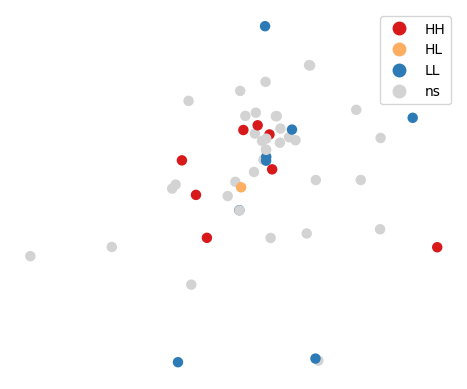

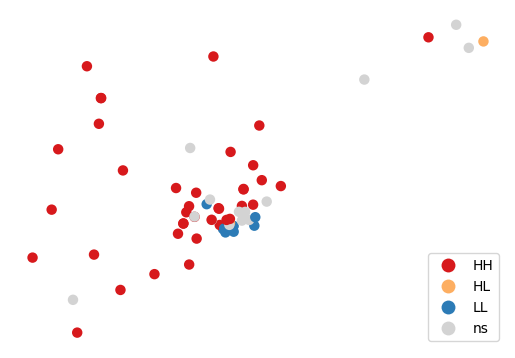

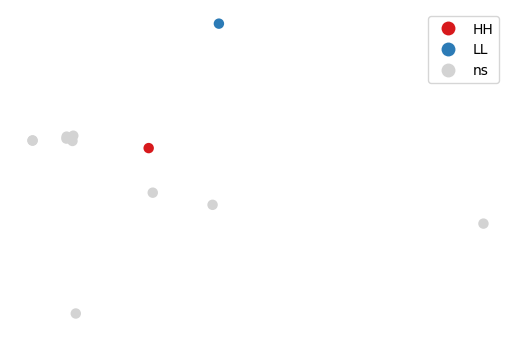

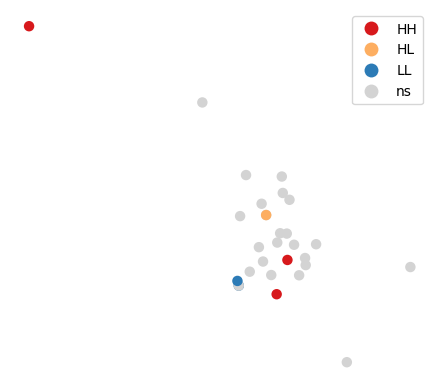

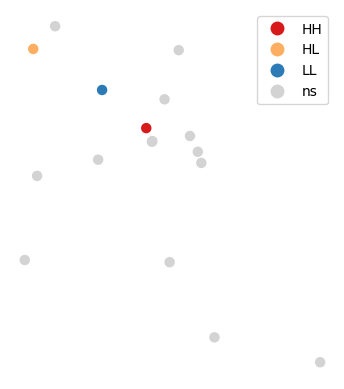

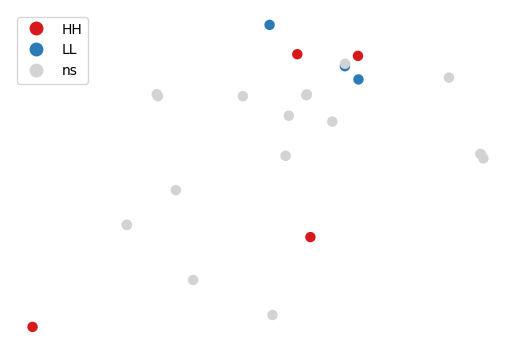

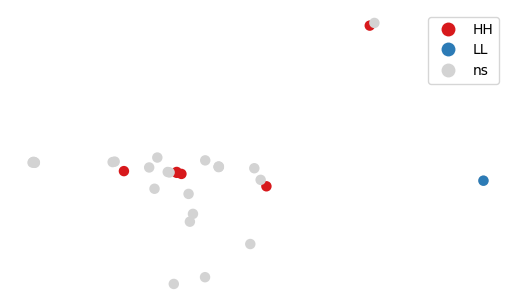

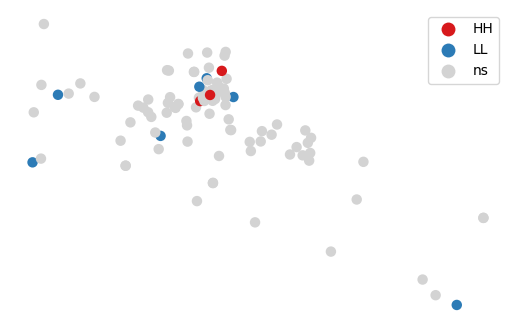

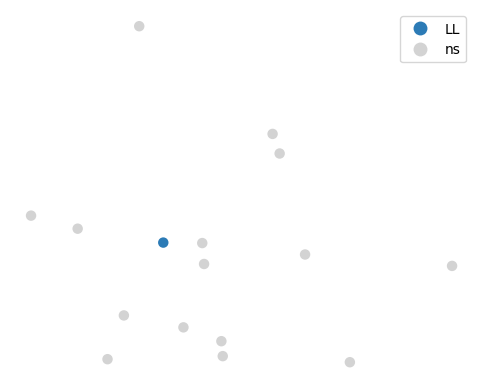

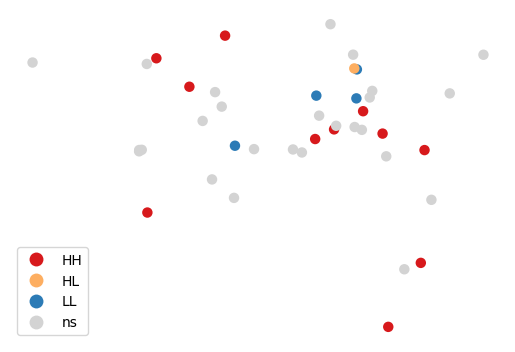

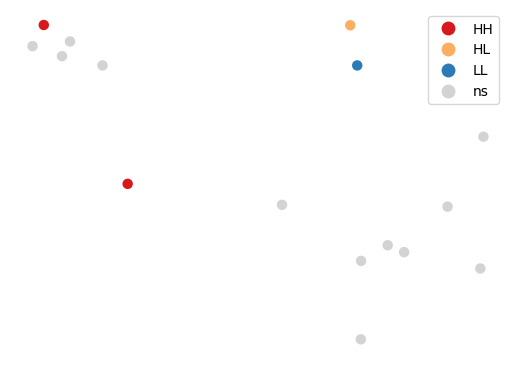

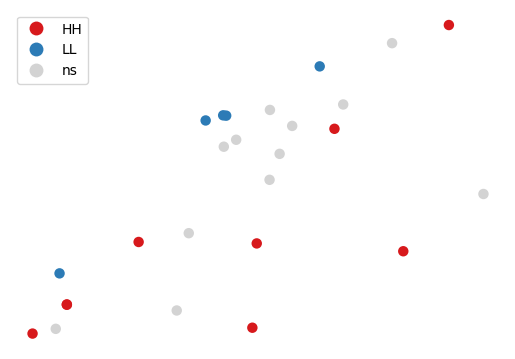

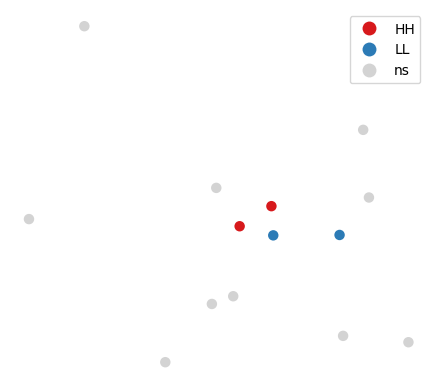

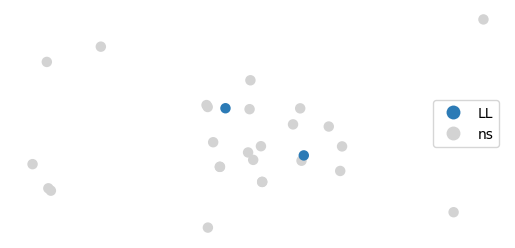

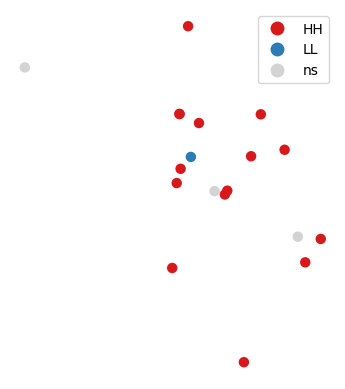

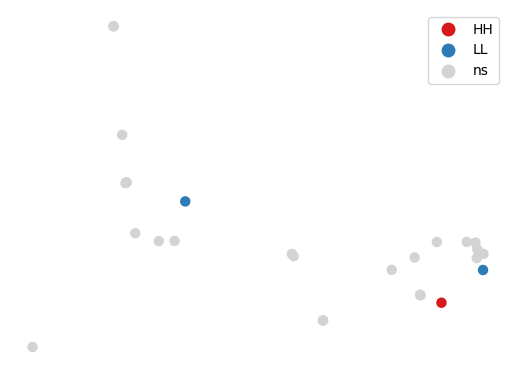

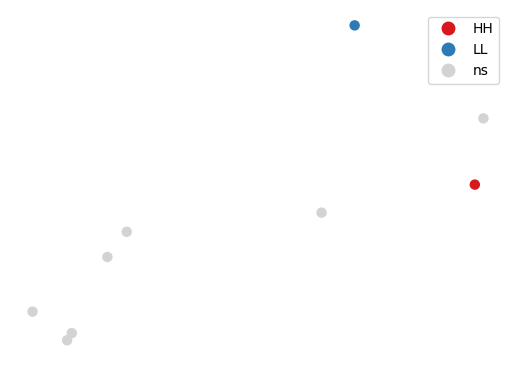

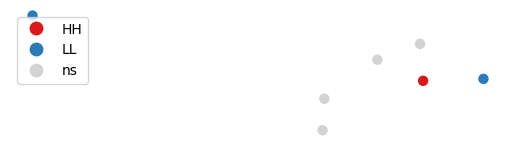

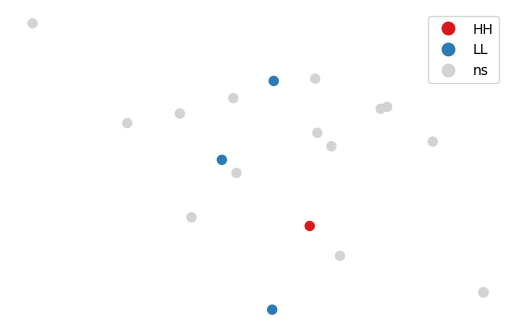

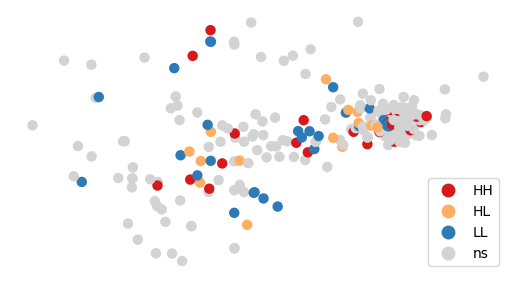

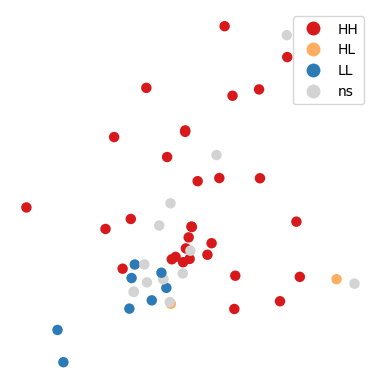

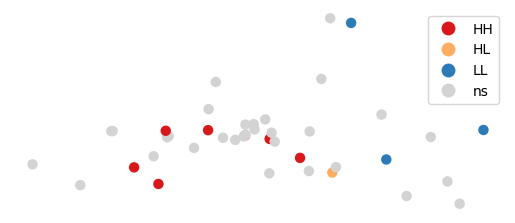

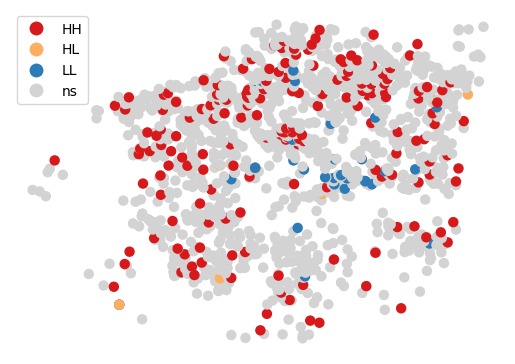

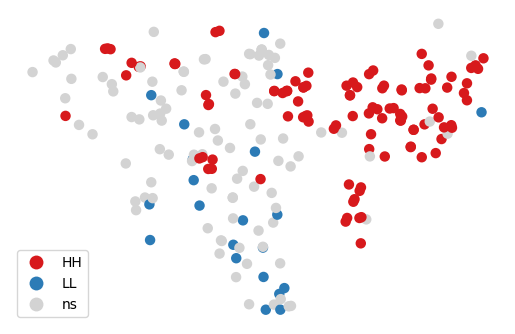

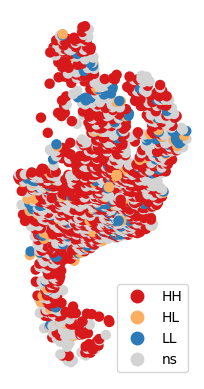

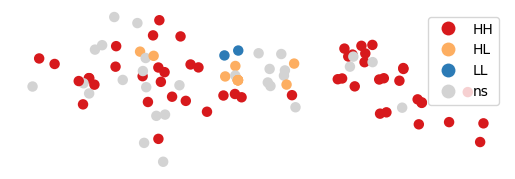

In [ ]:
# original run, using weights with fixed = F and no other parameter shifts

city_name_list = list(city_info_dict.keys())

summary_data = {}
for city_name in city_name_list:
    summary_data = get_religious_site_autocorrs(city_name, city_info_dict, relig_types, summary_data)

In [7]:
summary_data_df = pd.DataFrame.from_dict(summary_data,orient='index')
summary_data_df

,city_name,primary_type_1,primary_type_2,num_primary_type_1,num_primary_type_2,global_morans_i,global_morans_i_pstat,global_gearys,global_gearys_pstat,local_gi_prop_sig,local_gi_star_prop_sig,local_morans_prop_sig,Non-Significant,HH,LH,LL,HL
pristina,pristina,mosque,church,38,15,0.858637,0.043,0.131075,0.035,0.886792,0.245283,32.075472,0.679245,0.150943,0,0.150943,0.018868
prizren,prizren,mosque,church,51,14,0.927117,0.002,0.091393,0.010,0.969231,0.230769,78.461538,0.215385,0.600000,0,0.153846,0.030769
ferizaj,ferizaj,church,mosque,6,6,0.824420,0.174,0.160949,0.164,0.583333,0.083333,16.666667,0.833333,0.083333,0,0.083333,0.000000
gjakova,gjakova,mosque,church,19,10,0.717266,0.181,0.278954,0.202,0.793103,0.310345,20.689655,0.793103,0.103448,0,0.068966,0.034483
gjilan,gjilan,mosque,church,13,4,0.856554,0.134,0.132377,0.143,0.882353,0.294118,17.647059,0.823529,0.058824,0,0.058824,0.058824
mitrovica,mitrovica,mosque,church,20,5,0.883136,0.102,0.081262,0.103,0.920000,0.280000,28.000000,0.720000,0.160000,0,0.120000,0.000000
peja,peja,mosque,church,19,14,0.927583,0.002,0.072023,0.005,0.757576,0.363636,21.212121,0.787879,0.181818,0,0.030303,0.000000
skopje,skopje,church,mosque,65,33,0.898386,0.001,0.102694,0.001,0.887755,0.255102,10.204082,0.897959,0.030612,0,0.071429,0.000000
kumanovo,kumanovo,church,mosque,12,4,0.857498,0.126,0.129764,0.118,0.875000,0.062500,6.250000,0.937500,0.000000,0,0.062500,0.000000
bitola,bitola,church,mosque,38,4,0.685058,0.282,0.269647,0.448,0.952381,0.142857,38.095238,0.619048,0.261905,0,0.095238,0.023810


In [8]:
save_loc = '/mnt/c/Users/natra/Documents/Research/Identity-Conflict/results/basic_spatial_autocorr_cities_religious.csv'
summary_data_df.to_csv(save_loc,index=False)

## View Single City

In [ ]:
get_religious_site_autocorrs('prizren', city_info_dict, relig_types, {})